## Лабораторная работа № 3
## Выполнил: **Цыганов Никита Дмитриевич**
## **Цель:** используя библиотеку DeepFace реализовать систему верификации человека по изображению лица
## **Задание:**
## 1. Сделать свою фотографию, выполнить детектирование лица на изображении, сформировать вектор признаков лица, используя указанные в варианте задания детектор и модель
## 2. Захватить видеопоток с веб-камеры, выполнить верификацию в реальном масштабе времени
## 3. Определить устойчивость указанного в варианте задания модели и детектора к повороту и наклону головы.

## Отчёт должен включать эксперимент, а также описание используемого детектора и модели распознавания.

In [57]:
# Блок функции создания скриншота с веб камеры. Параметр first_photo отвечает за создание фото для сформирования вектора признаков лица

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8, first_photo=False, i = 0):
  js = Javascript('''
    async function takePhoto(quality, first_photo) {
      const div = document.createElement('div');

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  if first_photo: filename = "init.jpg"
  else: filename = 'photo' + str(i) + '.jpg'
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

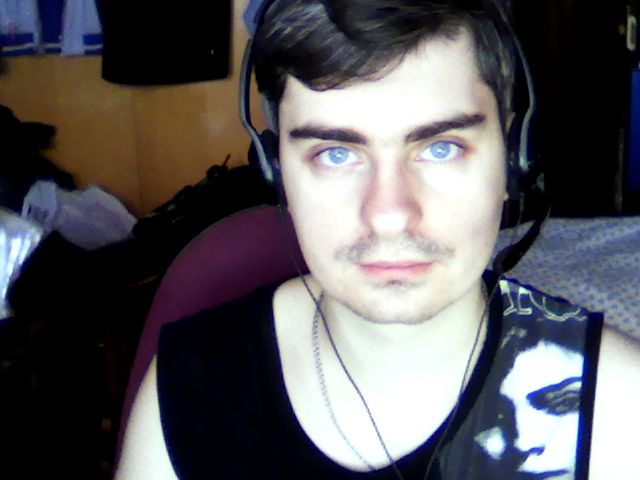

In [61]:
# Создаём фото для сформирования вектора признаков лица
from IPython.display import Image


take_photo(first_photo = True)

Image('init.jpg')

## **OpenFace** - реализация распознавания лиц с открытым исходным кодом, написанная на Python и Torch и основанная на глубоком обучении и нейронных сетях. Как таковая, она опирается на ряд компонентов, которые работают вместе как конвейеры, каждый из которых основывает свой вход на выходе предыдущего компонента. Это dlib и OpenVC, используемые для обнаружения, выравнивания и преобразования лиц; библиотека машинного обучения Torch для реализации глубокого обучения; и nn4 – сама модель нейронной сети.

## Типичный рабочий процесс начинается с подачи набора изображений в dlib, который затем делает свою магию и обнаруживает закрытые лица, размещая вокруг них ограничительные рамки и затем обрезая их до области шириной 96×96 пикселей. Затем лицо выравнивается и преобразуется, чтобы глаза и нижняя губа располагались в одном и том же месте на каждом изображении, поскольку лицо может иметь разную ориентацию. Недавно выпущенная версия OpenFace 0.2.0 улучшает эти процессы выравнивания и преобразования, удаляя избыточный цикл обнаружения лица, что вдвое сокращает время выполнения.

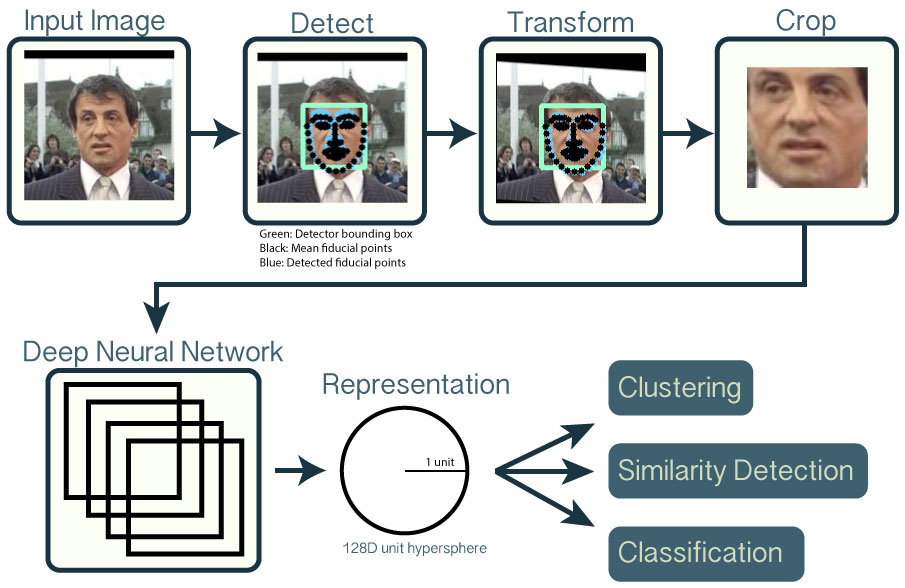

## Изображение лица, обработанное dlib, затем используется в качестве входных данных для компонента глубокой нейронной сети nn4, который отображает его на 128-мерную единичную гиперсферу, таким образом, представляя каждое лицо в 128 байтах. Благодаря тому, как работает процесс выравнивания, nn4 может, даже на этой ранней стадии, определить, что два лица не принадлежат одному и тому же человеку, если существует несоответствие (евклидовых) расстояний между характеристиками их представлений, расстояний, непосредственно соответствующих мере сходства лиц.

## **OpenCV** был запущен в Intel в 1999 году Гэри Брэдски с целью ускорения исследований и коммерческих применений компьютерного зрения в мире и для Intel, создавая потребность в таких приложениях для еще более мощных компьютеров.

## У OpenCV есть достаточно мощный функционал по детекту (определению) объектов на изображении. Реализовано это благодаря предварительно обученным моделям, основанным на нейросетях.

## Библиотека компьютерного зрения с открытым исходным кодом Intel может значительно упростить программирование компьютерного зрения. Она включает в себя расширенные возможности - распознавание лиц, отслеживание лиц, распознавание лиц, фильтрацию Калмана и различные методы искусственного интеллекта (ИИ) - в готовом виде. Кроме того, она предоставляет множество базовых алгоритмов компьютерного зрения через свои низкоуровневые API.

## Преимущество OpenCV состоит в том, что он является мультиплатформенным фреймворком; он поддерживает как Windows, так и Linux, а в последнее время и Mac OS X.

## OpenCV имеет так много возможностей, что на первый взгляд может показаться ошеломляющим. Хорошее понимание того, как работают эти методы, является ключом к получению хороших результатов при использовании OpenCV. К счастью, для начала достаточно общих знаний и понимания технологий.

## Функциональность OpenCV, которая будет использоваться для распознавания лиц, содержится в нескольких модулях. Ниже приводится краткое описание ключевых пространств имен:

## - Пространство имен CXCORE содержит базовые определения типов данных, методы линейной алгебры и статистики, функции постоянства и обработчики ошибок. Несколько странно, что здесь также расположены графические функции для рисования на изображениях.
## - Пространство имен CV содержит методы обработки изображений и калибровки камеры. Функции вычислительной геометрии также находятся здесь.
## - Пространство имен CVAUX описано в документации OpenCV как содержащее устаревший и экспериментальный код. Однако самые простые интерфейсы для распознавания лиц находятся в этом модуле. Код, стоящий за ними, специализируется на распознавании лиц, и они широко используются для этой цели.
## - Пространство имен ML содержит интерфейсы машинного обучения.
## - Пространство имен HighGUI содержит базовые интерфейсы ввода/вывода и возможности мультиплатформенного управления окнами.
## - Пространство имен CVCAM содержит интерфейсы для доступа к видео через DirectX на 32-битных платформах Windows.
## - Собственные лица (Eigenfaces) считаются самым простым методом точного распознавания лиц, но многие другие (гораздо более сложные) методы или комбинации нескольких методов немного более точны.

## Большинство ресурсов по распознаванию лиц предназначено для базовых нейронных сетей, которые обычно работают не так хорошо, как Eigenfaces. И, к сожалению, есть только некоторые базовые объяснения лучшего типа распознавания лиц, чем Eigenfaces, такие как распознавание по видео и другим методам на домашней странице распознавания лиц или на странице Википедии по 3D распознаванию лиц и странице моделей активного внешнего вида.

In [34]:
!pip install deepface

     |████████████████████████████████| 61 kB 2.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 12.7 MB/s 
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=dc74e12ad5c9fdaa6bc010080f946aa9dc3f9d4a694acb61683b5879ac4127af
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [63]:
# Обработка фото в "режиме онлайн", в бесконечном цикле генерируя новое изображение с веб-камеры
from deepface import DeepFace

model = "OpenFace"
backend = "opencv"
i = 0
while True:
  filename = take_photo(i = i)
  print(filename)
  try:
    result = DeepFace.verify(img1_path = "init.jpg", img2_path = 'photo' + str(i) + '.jpg', model_name = model, detector_backend = backend)
    print(result)
    Image('photo.jpg')
    i = i + 1
  except Exception as e:
    print("Can't recognize the face: ", e)

<IPython.core.display.Javascript object>

photo0.jpg
{'verified': True, 'distance': 0.08070046799621367, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo1.jpg
{'verified': True, 'distance': 0.04317994907461509, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo2.jpg
{'verified': True, 'distance': 0.049001719640677566, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo3.jpg
{'verified': False, 'distance': 0.10457956953201064, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo4.jpg
Can't recognize the face:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


<IPython.core.display.Javascript object>

photo4.jpg
Can't recognize the face:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


<IPython.core.display.Javascript object>

photo4.jpg
{'verified': False, 'distance': 0.3480542473753224, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo5.jpg
{'verified': False, 'distance': 0.29180381520036835, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo6.jpg
{'verified': True, 'distance': 0.01767964342384798, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo7.jpg
{'verified': False, 'distance': 0.1205069580617385, 'max_threshold_to_verify': 0.1, 'model': 'OpenFace', 'similarity_metric': 'cosine'}


<IPython.core.display.Javascript object>

photo8.jpg
Can't recognize the face:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


<IPython.core.display.Javascript object>

photo8.jpg
Can't recognize the face:  Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored